In [2]:
import pandas as pd
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn import set_config
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

In [3]:
#sklearn will return a pandas dataframe insted of a numpy array
set_config(transform_output="pandas")
random_state = 42
sns.set_style("darkgrid")


# Load Data

In [4]:
nba       = pd.read_csv('../data/nba/nba_salaries.csv')
insurance = pd.read_csv('../data/insurance/insurance.csv')
airline   = pd.read_csv('../data/airline/train.csv')
airbnb    = pd.read_csv('../data/airbnb/listings.csv')

# Visualizing Distributions

In [14]:
def visualize_effects_outliers_treatment(df_original: pd.DataFrame, 
                                        df_cleaned: pd.DataFrame,
                                        feature: str, 
                                        outlier_treatment: str):
    """
    Visualize the effect of the outlier treatment on a feature.


    Parameters
    ----------
    df_original : pd.DataFrame
        The original dataframe.
    df_cleaned : pd.DataFrame
        The cleaned dataframe.
    feature : str
        The feature to be visualized.
    outlier_treatment : str
        The treatment that was applied to the outliers.
    """
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))
    sns.histplot(x=feature, data=df_original, ax=ax[0], kde = True)
    sns.histplot(x=feature, data=df_cleaned, ax=ax[1], kde = True )
    ax[0].set_title(f'Raw {feature}')
    title = f'Cleaned {feature}\n'
    title += f'Outlier treatment: {outlier_treatment}'
    ax[1].set_title(title)
    plt.show()

# Managing outliers one feature at a time

## First Version

In [6]:
def clean_outliers(df: pd.DataFrame, features_list: list = None, 
                   outlier_treatment: str = None, output_column: str = None, 
                   skew_thresold: float = 1):
    '''
    Detect and treat outliers. Two criteria will be used to detect outliers:
        - empirical rule to detect outliers in normal distributions;
        - Tukey rule to detect outliers in distributions that are not normal.
    A distribution will be considered normal when its skewness is between -1 * skew_thresold and skew_thresold.
    One of the two criteria will be used to calculate max_thresh and min_thresh. Values above max_thresh and 
    values below min_thresh are considered outliers.
    

    Parameters
    ----------
    df : pd.DataFrame
        The dataframe to be cleaned.
    features_list : list, optional
        The list of features to be cleaned, by default, is None. If None, the function will clean all features.
    outlier_treatment : str, optional
        The treatment to be applied to outliers, by default, None. Can be 'remove'; 'replace'; 'impute', or None:
            - remove: rows containing outliers are completely removed;
            - replace: outliers above max_thresh and outliers below min_thresh are replaced by max_thresh and min_thresh, respectively;
            - impute: outliers above max_thresh and outliers below min_thresh are imputed using the Iterative imputer method form scikit-learn;
            - None: no treatment is applied to outliers.
    output_column : str, optional
        The name of the output column, by default is None. The output column will not be used when calculating the values to be imputed. 
        If None, it is considered that the output column is not in df.
    skew_thresold : float, optional
        The skewness threshold for a distribution to be considered normal, by default 1.

    Returns
    -------
    pd.DataFrame
        The cleaned dataframe.
    
    '''

    df = df.copy()
    
    if features_list is None:
        features_list = df.columns

    if outlier_treatment not in ['remove', 'replace', 'impute', None]:
        print(f'The outlier_treatment {outlier_treatment} is not valid. No treatment will be applied to outliers.')
        outlier_treatment = None

    #remove output_column from features_list. The output column can not be used when calculating the values to be imputed
    if output_column is not None and output_column in features_list:
        features_list_impute_method = features_list.copy()
        features_list_impute_method.remove(output_column)
    else:
        features_list_impute_method = features_list
 

    for feature in features_list:
        #test whether the feature is in the dataframe
        if feature in df.columns:
            #only numeric columns will be cleaned
            if pd.api.types.is_numeric_dtype(df[feature]):

                #test whether the feature has only one unique value
                if df[feature].nunique() == 1:
                    print(f'The feature {feature} has only one unique value and was therefore ignored.')

                #test whether the feature is binary (only true or false values)
                elif (set(df[feature].dropna().unique()).issubset({0, 1}) or
                        set(df[feature].dropna().unique()).issubset({True, False})):
                    print(f'The feature {feature} is binary (only true or false values) and was therefore ignored.')

                # look for outliers
                else:
                    #test whether the distribution is normal
                    skew = df[feature].skew()
                    if skew > -1 * skew_thresold and skew < skew_thresold:
                        #empirical rule to detect outliers in normal distributions
                        min_thresh = df[feature].mean() - 3 * df[feature].std()
                        max_thresh = df[feature].mean() + 3 * df[feature].std()
                    else: 
                        #apply the Tukey rule to detect outliers in distributions that are not normal
                        q1 = df[feature].quantile(0.25)
                        q3 = df[feature].quantile(0.75)
                        iqr = q3 - q1 #interquartile range
                        max_thresh = q3 + 1.5 * (iqr) 
                        min_thresh = q1 - 1.5 * (iqr)

                    #values above max_thresh and values below min_thresh are considered outliers
                    count_max_outlier = len(df.loc[df[feature] > max_thresh])
                    count_min_outlier = len(df.loc[df[feature] < min_thresh])
                    print(f'The feature {feature} has {count_max_outlier} values above {max_thresh}')
                    print(f'The feature {feature} has {count_min_outlier} values below {min_thresh}')

                    #deal with outliers
                    if count_max_outlier > 0 and outlier_treatment != 'impute':
                        if outlier_treatment == 'remove':
                            print(f'{count_max_outlier} values above {max_thresh} were removed in feature {feature}')  
                            df = df[df[feature] < max_thresh]

                        elif outlier_treatment == 'replace':
                            if not pd.api.types.is_float_dtype(df[feature]):
                                df[feature] = df[feature].astype(float) #convert to float
                            print(f'{count_max_outlier} values above {max_thresh} were replaced in feature {feature}')  
                            df.loc[df[feature] > max_thresh, feature] = max_thresh
                        else:
                            continue

                    if count_min_outlier > 0 and outlier_treatment != 'impute':
                        if outlier_treatment == 'remove':
                            print(f'{count_min_outlier} values below {min_thresh} were removed in feature {feature}')  
                            df = df[df[feature] > min_thresh]
                        elif outlier_treatment == 'replace':
                            if not pd.api.types.is_float_dtype(df[feature]):
                                df[feature] = df[feature].astype(float) #convert to float
                            print(f'{count_min_outlier} values below {min_thresh} were replaced in feature {feature}')  
                            df.loc[df[feature] < min_thresh, feature] = min_thresh
                        else:
                            continue
                    #impute method
                    has_outliers = count_max_outlier > 0 or count_min_outlier > 0
                    if outlier_treatment == 'impute' and has_outliers:
                        #numeric_columns = df.select_dtypes(include = 'number').columns.to_list()
                        df_temp = df.copy()
                        df_temp.loc[df_temp[feature] > max_thresh, feature] = np.nan
                        df_temp.loc[df_temp[feature] < min_thresh, feature] = np.nan
                        #if output_column is not None and output_column in numeric_columns:
                        #    numeric_columns.remove(output_column)
                        df_temp = pd.get_dummies(df_temp, drop_first = True)
                        imputer = IterativeImputer(max_iter=10, random_state = random_state)
                        df_temp = imputer.fit_transform(df_temp)
                        df[feature] = df_temp[feature]

            else:
                print(f'The feature {feature} is not numeric and was therefore ignored')

        else:
            print(f'A {feature} não foi encontrada no dataframe e foi ignorada')

    return df



## Refactored Version

In [7]:
def calculate_outlier_threshold(df: pd.DataFrame, feature: str, 
                               skew_thresold: float = 1) -> tuple[float, float]: 
    """
    Calculate the inferior and superior thresholds for outlier detection.
    Values above max_thresh and values below min_thresh are considered outliers

    Args:
        df (pd.DataFrame): The dataframe containing the feature.
        feature (str): The name of the feature to be processed.
        skew_thresold (float): The skewness threshold used to determine whether the distribution is normal or not.

    Returns:    
        tuple: A tuple containing the inferior and superior thresholds for outlier detection.
    """
    skew = df[feature].skew()
    if skew > -1 * skew_thresold and skew < skew_thresold:
        #empirical rule to detect outliers in normal distributions
        min_thresh = df[feature].mean() - 3 * df[feature].std()
        max_thresh = df[feature].mean() + 3 * df[feature].std()
    else: 
        #apply the Tukey rule to detect outliers in distributions that are not normal
        q1 = df[feature].quantile(0.25)
        q3 = df[feature].quantile(0.75)
        iqr = q3 - q1 #interquartile range
        max_thresh = q3 + 1.5 * (iqr) 
        min_thresh = q1 - 1.5 * (iqr)
    
    return (min_thresh, max_thresh)    

def clean_outliers(df: pd.DataFrame, features_list: list = None, 
                   outlier_treatment: str = None, output_column: str = None, 
                   skew_thresold: float = 1) -> pd.DataFrame:
    '''
    Detect and treat outliers. Two criteria will be used to detect outliers:
        - empirical rule to detect outliers in normal distributions;
        - Tukey rule to detect outliers in distributions that are not normal.
    A distribution will be considered normal when its skewness is between -1 * skew_thresold and skew_thresold.
    One of the two criteria will be used to calculate max_thresh and min_thresh. Values above max_thresh and 
    values below min_thresh are considered outliers.
    

    Parameters
    ----------
    df : pd.DataFrame
        The dataframe to be cleaned.
    features_list : list, optional
        The list of features to be cleaned, by default, is None. If None, the function will clean all features.
    outlier_treatment : str, optional
        The treatment to be applied to outliers, by default, None. Can be 'remove'; 'replace'; 'impute', or None:
            - remove: rows containing outliers are completely removed;
            - replace: outliers above max_thresh and outliers below min_thresh are replaced by max_thresh and min_thresh, respectively;
            - impute: outliers above max_thresh and outliers below min_thresh are imputed using the Iterative imputer method form scikit-learn;
            - None: no treatment is applied to outliers.
    output_column : str, optional
        The name of the output column, by default is None. The output column will not be used when calculating the values to be imputed. 
        If None, it is considered that the output column is not in df.
    skew_thresold : float, optional
        The skewness threshold for a distribution to be considered normal, by default 1.

    Returns
    -------
    pd.DataFrame
        The cleaned dataframe.
    
    '''

    df = df.copy()
    df = df.dropna()
    
    if features_list is None:
        features_list = df.columns.to_list()

    if outlier_treatment not in ['remove', 'replace', 'impute', None]:
        print(f'The outlier_treatment {outlier_treatment} is not valid. No treatment will be applied to outliers.')
        outlier_treatment = None

    #remove output_column from features_list. The output column can not be used when calculating the values to be imputed
    if output_column is not None and output_column in features_list:
        features_list_impute_method = features_list.copy()
        features_list_impute_method.remove(output_column)
    else:
        features_list_impute_method = features_list
 

    for feature in features_list:
        #test whether the feature is in the dataframe
        if feature in df.columns:
            #only numeric columns will be cleaned
            if pd.api.types.is_numeric_dtype(df[feature]):

                #test whether the feature has only one unique value
                if df[feature].nunique() == 1:
                    print(f'The feature {feature} has only one unique value and was therefore ignored.')

                #test whether the feature is binary (only true or false values)
                elif (set(df[feature].dropna().unique()).issubset({0, 1}) or
                        set(df[feature].dropna().unique()).issubset({True, False})):
                    print(f'The feature {feature} is binary (only true or false values) and was therefore ignored.')

                # look for outliers
                else:
                    #calculate max_thresh and min_thresh
                    
                    min_thresh, max_thresh = calculate_outlier_threshold(df, feature, skew_thresold)
                    

                    #values above max_thresh and values below min_thresh are considered outliers
                    count_max_outlier = len(df.loc[df[feature] > max_thresh])
                    count_min_outlier = len(df.loc[df[feature] < min_thresh])
                    print(f'The feature {feature} has {count_max_outlier} values above {max_thresh}')
                    print(f'The feature {feature} has {count_min_outlier} values below {min_thresh}')

                    has_outliers = count_max_outlier > 0 or count_min_outlier > 0

                    if not has_outliers:                  
                        continue

                    if outlier_treatment == 'remove':
                        df = df[(df[feature] >= min_thresh) & (df[feature] <= max_thresh)]
                        print(f'{feature}: outliers removed')

                    elif outlier_treatment == 'replace':
                        if not pd.api.types.is_float_dtype(df[feature]):
                            df[feature] = df[feature].astype(float) #convert to float
                        print(f'{feature}: outliers replaced')
                        df.loc[df[feature] > max_thresh, feature] = max_thresh
                        df.loc[df[feature] < min_thresh, feature] = min_thresh

                    elif outlier_treatment == 'impute':
                        df_temp = df[features_list_impute_method].copy()
                        df_temp.loc[df_temp[feature] > max_thresh, feature] = np.nan
                        df_temp.loc[df_temp[feature] < min_thresh, feature] = np.nan

                        df_temp = pd.get_dummies(df_temp, drop_first = True)
                        imputer = IterativeImputer(max_iter=10, random_state = random_state)
                        df_temp = imputer.fit_transform(df_temp)
                        df[feature] = df_temp[feature]

            else:
                print(f'The feature {feature} is not numeric and was therefore ignored')

        else:
            print(f'A {feature} não foi encontrada no dataframe e foi ignorada')

    return df




The feature age has 0 values above 81.35690654870976
The feature age has 0 values below -2.942855726587176
The feature sex is not numeric and was therefore ignored
The feature bmi has 4 values above 48.95795759602359
The feature bmi has 0 values below 12.368836125949507
bmi: outliers removed
The feature children has 18 values above 4.716345622635256
The feature children has 0 values below -2.522942324284431
children: outliers removed
The feature smoker is not numeric and was therefore ignored
The feature region is not numeric and was therefore ignored
The feature charges has 129 values above 35232.529987500006
The feature charges has 0 values below -13588.807712500002
charges: outliers removed


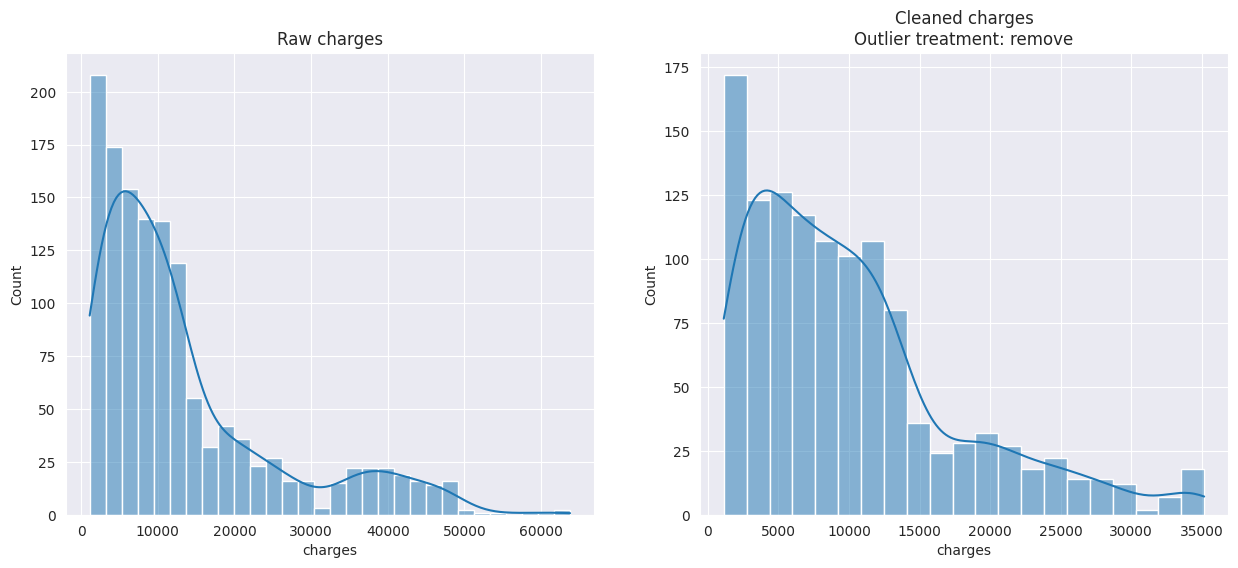

In [15]:
insurance_cleaned = clean_outliers(insurance, 
                                   outlier_treatment = 'remove')

visualize_effects_outliers_treatment(insurance,
                                     insurance_cleaned,
                                     'charges',
                                     'remove')

The feature age has 0 values above 81.35690654870976
The feature age has 0 values below -2.942855726587176
The feature sex is not numeric and was therefore ignored
The feature bmi has 4 values above 48.95795759602359
The feature bmi has 0 values below 12.368836125949507
bmi: outliers replaced
The feature children has 18 values above 4.711396007088641
The feature children has 0 values below -2.521560431602842
children: outliers replaced
The feature smoker is not numeric and was therefore ignored
The feature region is not numeric and was therefore ignored
The feature charges has 139 values above 34489.350562499996
The feature charges has 0 values below -13109.1508975
charges: outliers replaced


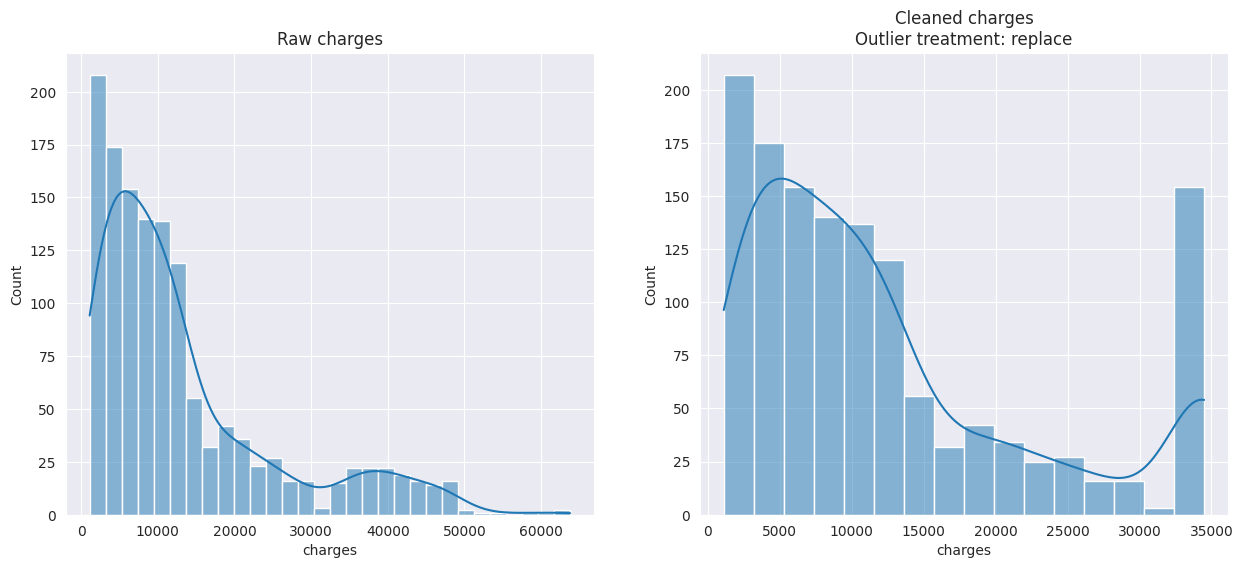

In [16]:
insurance_cleaned = clean_outliers(insurance, 
                                   outlier_treatment = 'replace')

visualize_effects_outliers_treatment(insurance,
                                     insurance_cleaned,
                                     'charges',
                                     'replace')

The feature age has 0 values above 81.35690654870976
The feature age has 0 values below -2.942855726587176
The feature sex is not numeric and was therefore ignored
The feature bmi has 4 values above 48.95795759602359
The feature bmi has 0 values below 12.368836125949507
The feature children has 18 values above 4.711396007088641
The feature children has 0 values below -2.521560431602842
The feature smoker is not numeric and was therefore ignored
The feature region is not numeric and was therefore ignored
The feature charges has 139 values above 34489.350562499996
The feature charges has 0 values below -13109.1508975


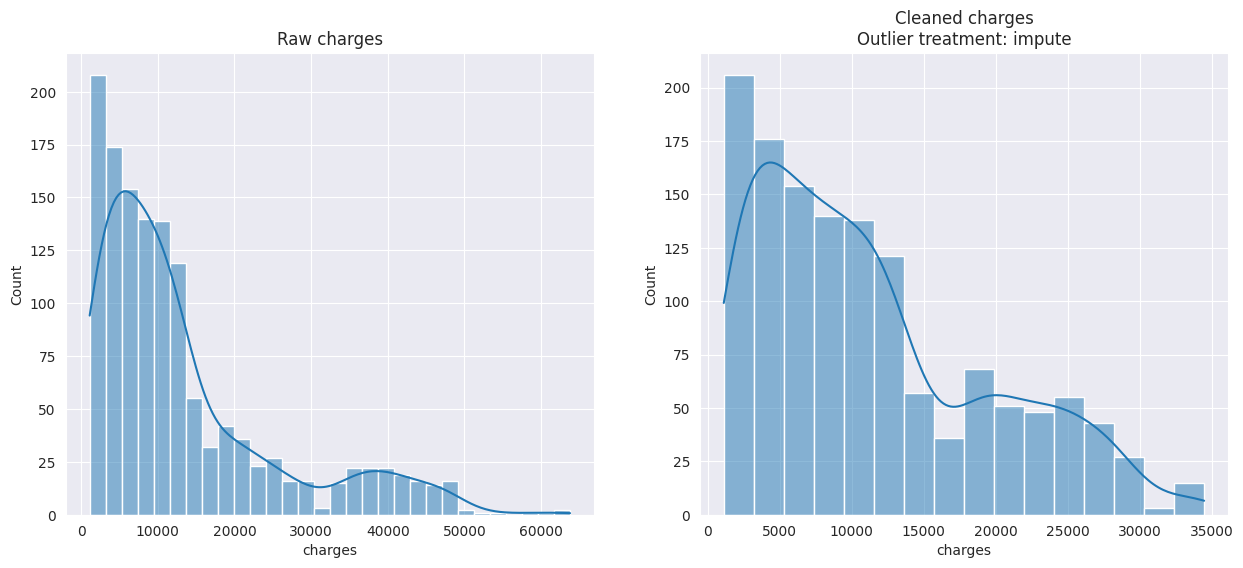

In [18]:
insurance_cleaned = clean_outliers(insurance, 
                                   outlier_treatment = 'impute')

visualize_effects_outliers_treatment(insurance,
                                     insurance_cleaned,
                                     'charges',
                                     'impute')

# Managing Outliers all features at once using DBSCAN

In [203]:
def search_eps_dbscan(df: pd.DataFrame, distance_metric: str = 'manhattan', 
                      min_samples: int = 5, eps_step : float = 0.01, desired_percentage_outliers : float = 0.02 ):

    '''
    Function to look for the best eps value for DBSCAN. Different eps values are tested to determine the proportion of outliers they produce.

    Parameters
    ----------
    df : pd.DataFrame
        The dataframe to be cleaned.
    distance_metric : str, optional
        The distance metric to be used in DBSCAN. The default is 'manhattan'. This metric is used by 
        DBSCAN to calculate the distance between points.
    min_samples : int, optional          
        The minimum samples to be used in DBSCAN. The default is 5. It is the maximum distance between 
        two samples for one to be considered as in the neighborhood of the other.The larger the eps value, 
        the fewer outliers there will be.
    eps_step : float, optional
        The step size to be used in the eps search. The default is 0.01. The step_size is used to increment
        the eps value.    
    desired_percentage_outliers : float, optional
        The desired percentage of outliers to be removed. The default is 0.02. The function will return the eps value
        that produces the desired percentage of outliers.
        
    Returns
    ------- 
    eps_percentage_outliers : pandas DataFrame
        A dataframe with the eps values and the percentage of outliers they produce.
    desired_percentage_outliers : float
        The eps value that produces the desired percentage of outliers.              
    '''
    
    df_temp = df.copy()

    #remove NaN
    initial_number_of_columns = df.shape[1]
    initial_number_of_rows = df.shape[0]
    initial_number_of_nan = df_temp.isna().sum().sum()  
    print(f'Number of missing values: {initial_number_of_nan}')

    df_temp = df_temp.dropna(axis = 'columns', how = 'all')
    df_temp = df_temp.dropna(axis = 'rows', how = 'any')

    final_number_of_columns = df_temp.shape[1]
    final_number_of_rows = df_temp.shape[0]

    print(f'Number of columns removed: {initial_number_of_columns - final_number_of_columns}')
    print(f'Number of rows removed: {initial_number_of_rows - final_number_of_rows}')
    print(f'Number of missing values after cleaning: {df_temp.isna().sum().sum()}')

    #Transform categorical variables 
    df_temp = pd.get_dummies(df_temp, drop_first = True)

    #Min max Scaler
    min_max_scaler = MinMaxScaler()
    df_temp = min_max_scaler.fit_transform(df_temp)

    #test DBSCAN using different eps to determine the number of outliers they produce
    eps_percentage_outliers = {'eps' : [],
                               'percentage_outliers(%)' : []}
    num_outliers = len(df_temp)
    eps = 0
    while num_outliers > 0:
        eps += eps_step
        dba = DBSCAN(eps = eps, min_samples = min_samples, metric=distance_metric, n_jobs = -1)
        dba.fit(df_temp)
        labels = dba.labels_
        num_outliers = np.count_nonzero(labels == -1)
        eps_percentage_outliers['eps'].append(eps)
        eps_percentage_outliers['percentage_outliers(%)'].append(round(100 * num_outliers/len(df_temp), 2))
    eps_percentage_outliers = pd.DataFrame(eps_percentage_outliers) 
    
    #look for the eps value that produces the desired percentage of outliers
    eps_percentage_outliers['diff'] = eps_percentage_outliers['percentage_outliers(%)'] - 100 * desired_percentage_outliers
    eps_percentage_outliers['diff'] = np.abs(eps_percentage_outliers['diff'])
    idx_min = eps_percentage_outliers['diff'].idxmin()
    desired_eps = round(eps_percentage_outliers.loc[idx_min, 'eps'], 2)
    percentage_outliers = eps_percentage_outliers.loc[idx_min, 'percentage_outliers(%)']

    #plot a lineplot with the eps values and the percentage of outliers they produce
    ax = sns.lineplot(data = eps_percentage_outliers , x = 'eps', y = 'percentage_outliers(%)')
    plt.scatter(desired_eps, percentage_outliers)
    text = f'eps = {desired_eps} \n'
    text += f'percentage_outliers(%) = {percentage_outliers}'
    plt.annotate(text, 
                xy=(desired_eps, percentage_outliers), 
                xytext=(desired_eps + 0.1, percentage_outliers + 0.1),
                arrowprops=dict(arrowstyle='->', color='gray'))
    plt.show()


    return eps_percentage_outliers, desired_eps
    

In [ ]:
def clean_outliers_using_DBscan(df: pd.DataFrame, eps: float, distance_metric: str = 'manhattan', 
                                min_samples: int = 5):
    
    '''
    Funcion to remove outliers using DBSCAN

    Parameters
    ----------
    df : pandas DataFrame
        The dataframe to be cleaned.
    eps : float
        The eps value to be used in DBSCAN. This value is the maximum distance between two samples for one to be 
        considered as in the neighborhood of the other.
    distance_metric : str, optional          
        The metric to be used in DBSCAN. The default is 'manhattan'. It is the metric used to calculate the distance between points.
    min_samples : int, optional          
        The minimum samples to be used in DBSCAN. The default is 5. It is the maximum distance between 
        two samples for one to be considered as in the neighborhood of the other.The larger the eps value, 
        the fewer outliers there will be.

    Returns
    ------- 
    df : pandas DataFrame
        The cleaned dataframe.
    '''

    df = pd.copy(df)
    df_temp = df.copy()

    #remove NaN
    initial_number_of_columns = df.shape[1]
    initial_number_of_rows = df.shape[0]
    initial_number_of_nan = df_temp.isna().sum().sum()  
    print(f'Number of missing values: {initial_number_of_nan}')

    df_temp = df_temp.dropna(axis = 'columns', how = 'all')
    df_temp = df_temp.dropna(axis = 'rows', how = 'any')

    final_number_of_columns = df_temp.shape[1]
    rows_no_nan = df_temp.shape[0]

    print(f'Number of columns removed: {initial_number_of_columns - final_number_of_columns}')
    print(f'Number of rows removed: {initial_number_of_rows - rows_no_nan}')
    print(f'Number of missing values after cleaning: {df_temp.isna().sum().sum()}')

    #Transform categorical variables 
    df_temp = pd.get_dummies(df_temp, drop_first = True)

    #Min max Scaler
    min_max_scaler = MinMaxScaler()
    df_temp = min_max_scaler.fit_transform(df_temp)

    #DBSCAN to look for outliers
    dba = DBSCAN(eps = eps, min_samples = min_samples, metric=distance_metric, n_jobs = -1)
    dba.fit(df_temp)
    labels = dba.labels_
    df_temp['labels'] = labels
    number_outliers = np.count_nonzero(labels == -1)
    print(f'Number of outliers: {number_outliers}')

    #remove outliers
    index_outliers = df_temp[df_temp['labels'] == -1].index
    df = df.drop(index_outliers)

    print(f'Percentage of rows removed: {(number_outliers / rows_no_nan) * 100}%')    

    return df